In [1]:
from amptools import process
import os
from obspy import read
from obspy import Stream
from obspy import UTCDateTime
from obspy.signal.util import next_pow_2
import matplotlib.pyplot as plt
import warnings

size=(1000, 500)
os.chdir('../tests/data/process')
warnings.filterwarnings('ignore')

Missing config file /Users/jrekoske/.amptools/config.yml, setting config to default config.


# Processing Workflow

![title](Processing Flow.png)

## Load in data

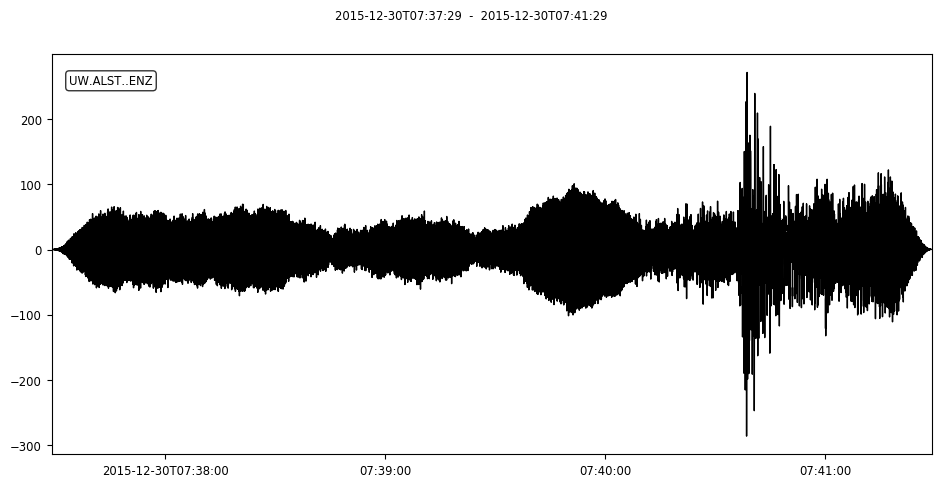

In [2]:
ALST_st = read('ALSTENZ.sac')
ALST_tr = ALST_st[0]
ALST_tr_mul = ALST_tr.copy()

org_time = UTCDateTime('2015-12-30T07:39:29')
ALST_tr.plot(size=size)

In [3]:
# Check amplitude
process.check_max_amplitude(ALST_tr)

True

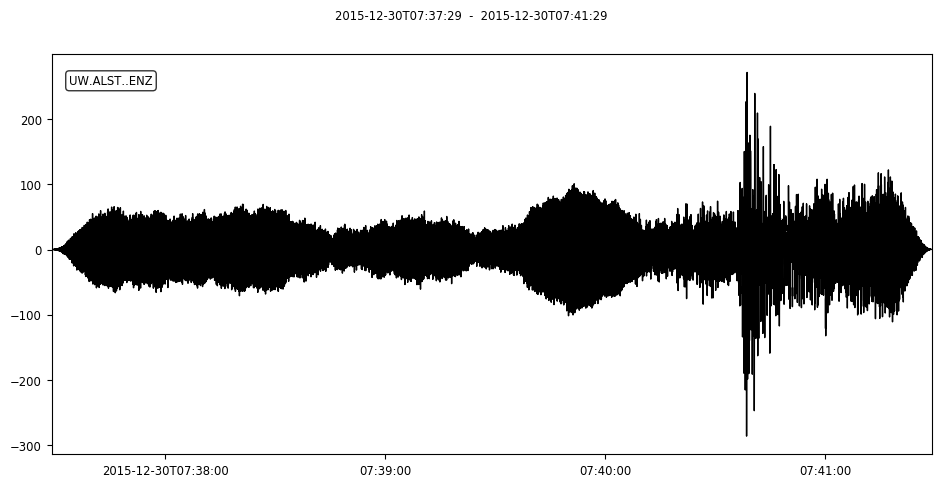

In [4]:
# Trim
ALST_tr_trim = process.trim_total_window(ALST_tr, org_time, ALST_tr.stats.sac.dist)
ALST_tr_trim.plot(size=size)

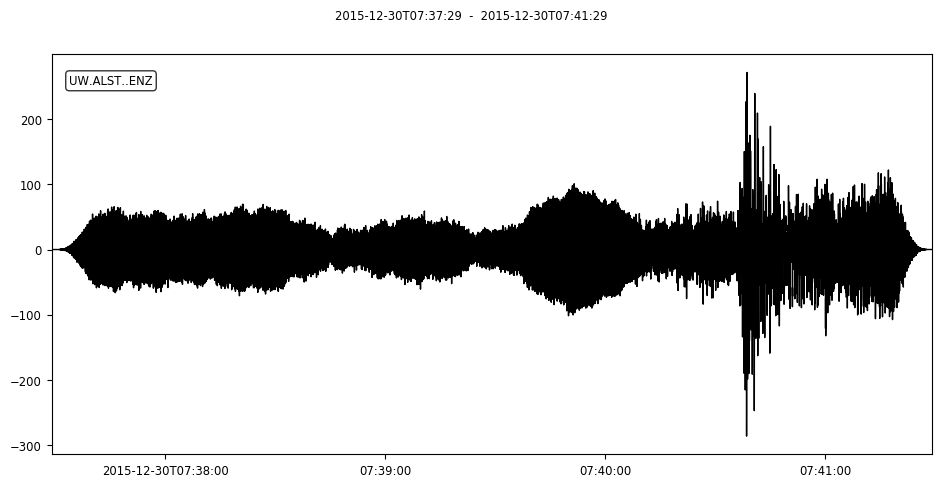

In [5]:
# Taper
ALST_tr_taper = process.taper(ALST_tr_trim, max_percentage=0.05)
ALST_tr_taper.plot(size=size)

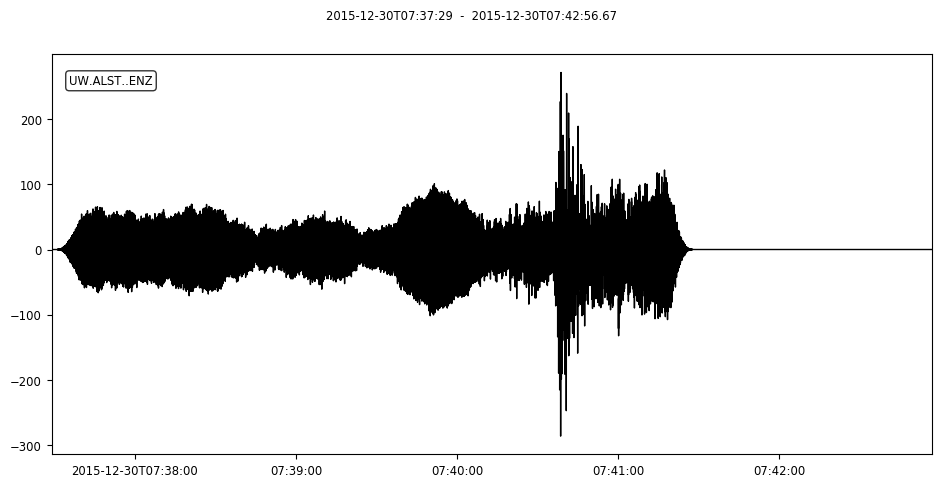

32768


In [6]:
# Zero pad
before_padding_endtime = ALST_tr_taper.stats.endtime
ALST_tr_pad = process.zero_pad(ALST_tr_taper)
ALST_tr_pad.plot(size=size)
print(ALST_tr_pad.stats.npts)

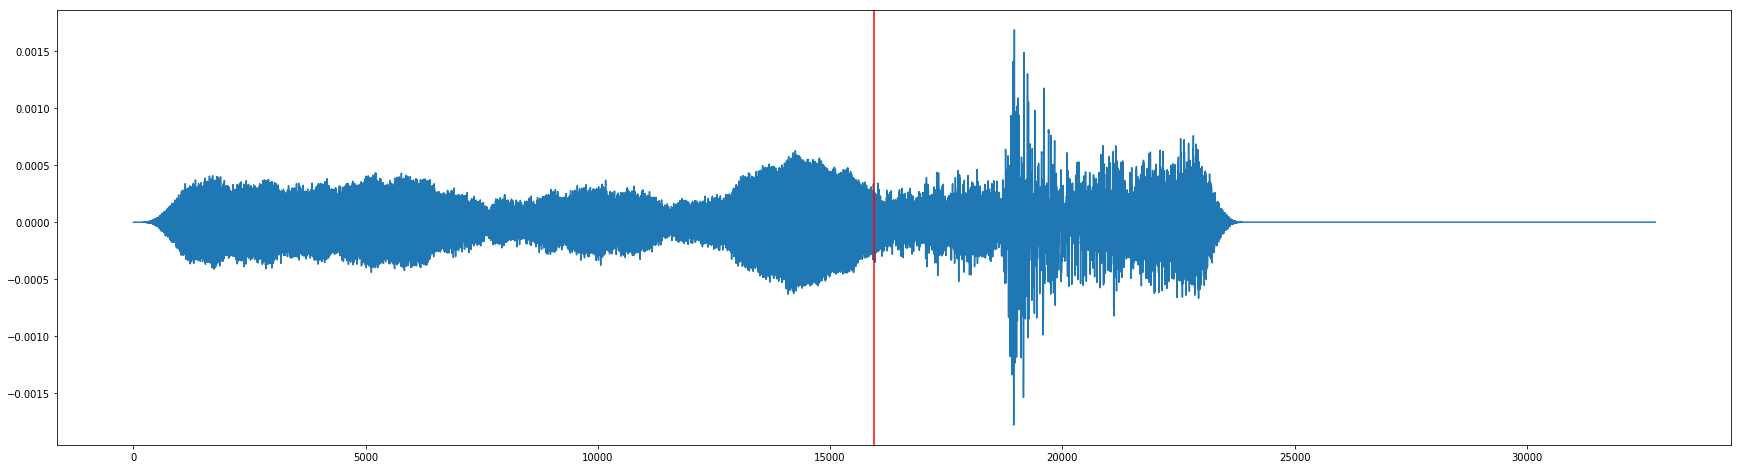

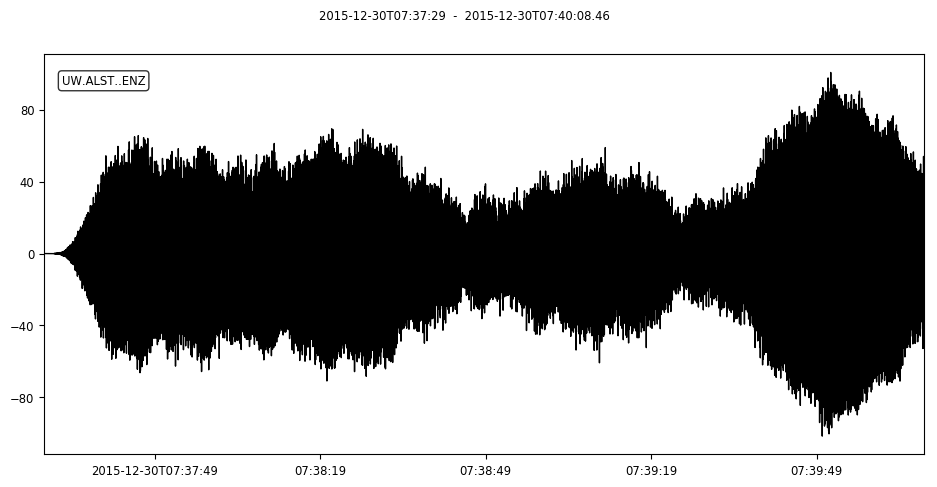

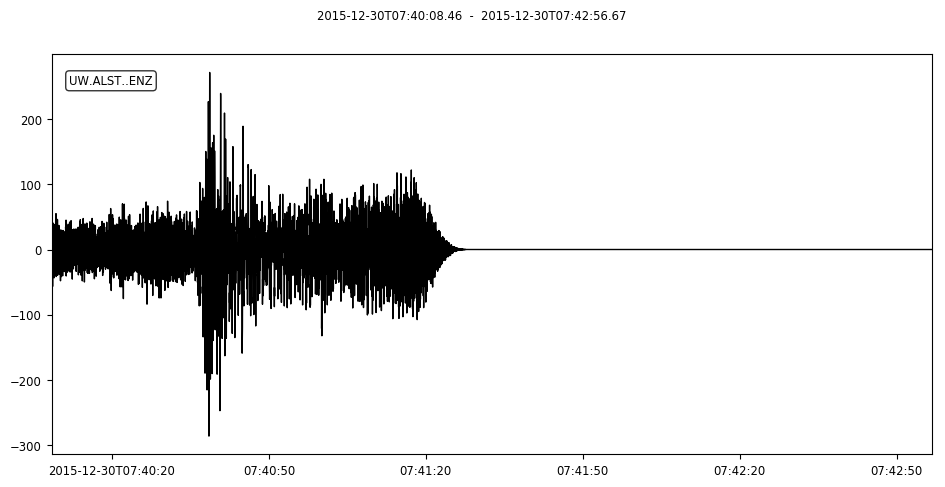

In [7]:
# Split signal and noise
signal, noise = process.split_signal_and_noise(ALST_tr_pad, org_time, ALST_tr.stats.sac.dist)
plt.figure(figsize=(30,8))
plt.plot(ALST_tr_pad.data)
plt.axvline(x=(noise.stats.endtime-ALST_tr_pad.stats.starttime) / ALST_tr_pad.stats.delta, color='red')
plt.plot()

noise.plot(size=size)
signal.plot(size=size)

[0.439453125, 11.3067626953125]


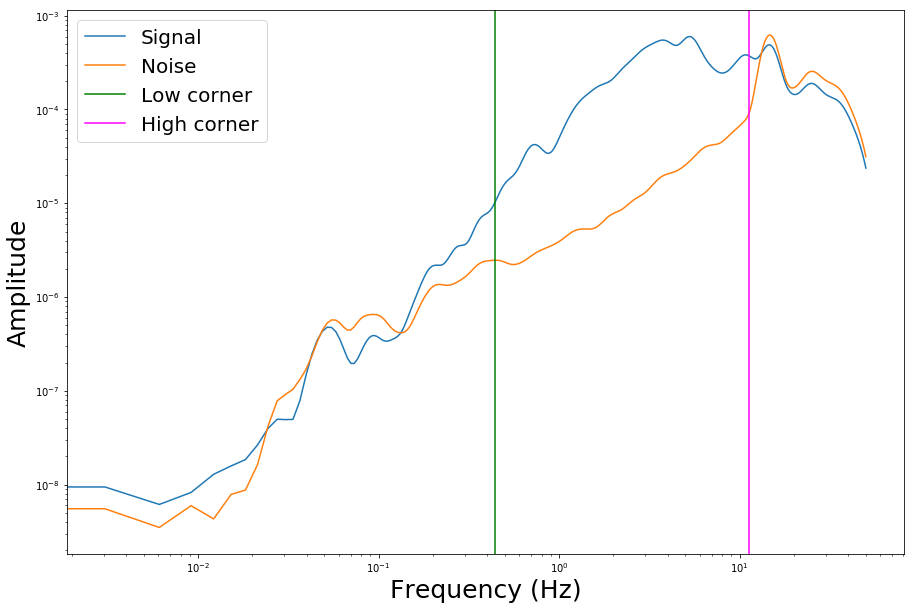

In [8]:
# Find corner frequencies
nfft = max(next_pow_2(signal.stats.npts), next_pow_2(noise.stats.npts))
signal_spectrum, signal_freqs = process.fft_smooth(signal, nfft)
noise_spectrum, noise_freqs = process.fft_smooth(noise, nfft)

corners = process.get_corner_frequencies(ALST_tr_pad, org_time, ALST_tr_pad.stats.sac.dist, f_a=0.5, f_b=5.0)
print(corners)

plt.figure(figsize=(15,10))
plt.plot(signal_freqs, signal_spectrum, label='Signal')
plt.plot(noise_freqs, noise_spectrum, label='Noise')
plt.axvline(x=corners[0], label='Low corner', color='green')
plt.axvline(x=corners[1], label='High corner', color='magenta')
plt.xlabel('Frequency (Hz)', fontsize=25)
plt.ylabel('Amplitude', fontsize=25)
plt.xscale('log')
plt.yscale('log')
plt.legend(fontsize=20)
plt.show()

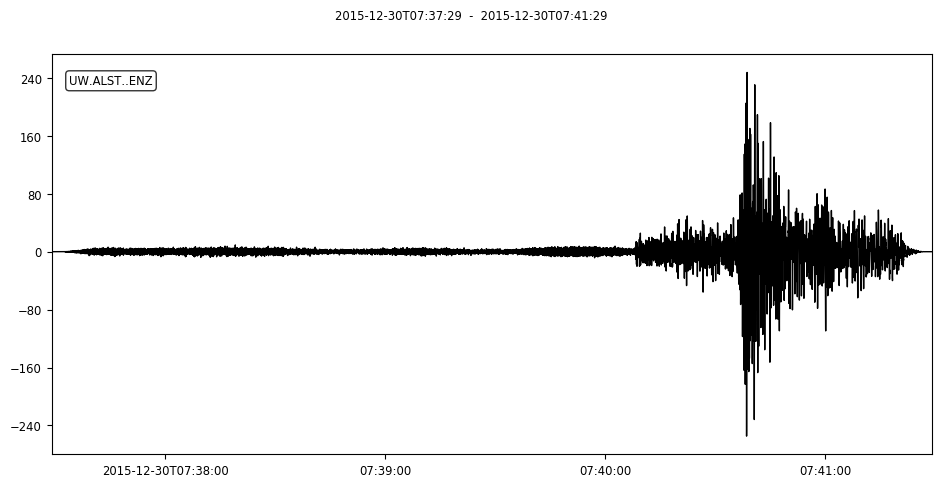

In [17]:
# Filter the waveform
process.filter_waveform(ALST_tr_pad, 'highpass', zerophase=True, corners=5, freqmin=corners[0])
ALST_tr_pad.plot(size=size)

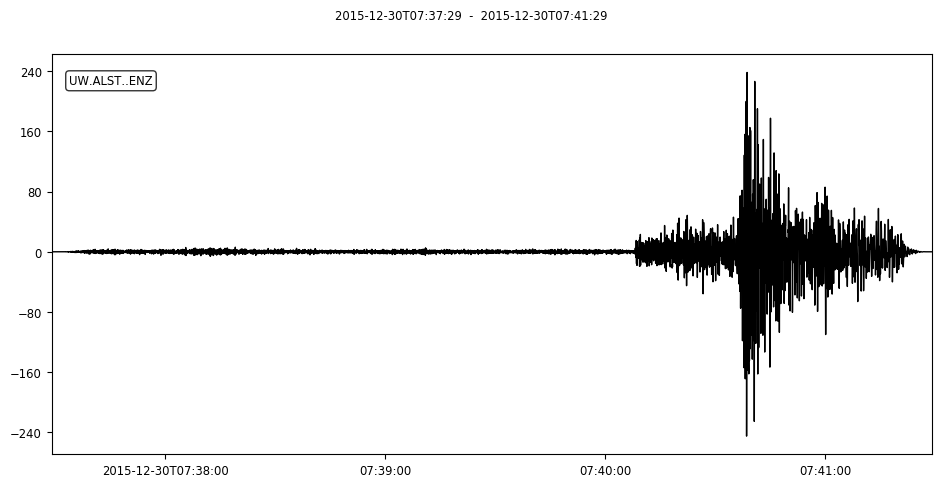

In [18]:
process.filter_waveform(ALST_tr_pad, 'lowpass', zerophase=True, corners=5, freqmax=corners[1])
ALST_tr_pad.plot(size=size)

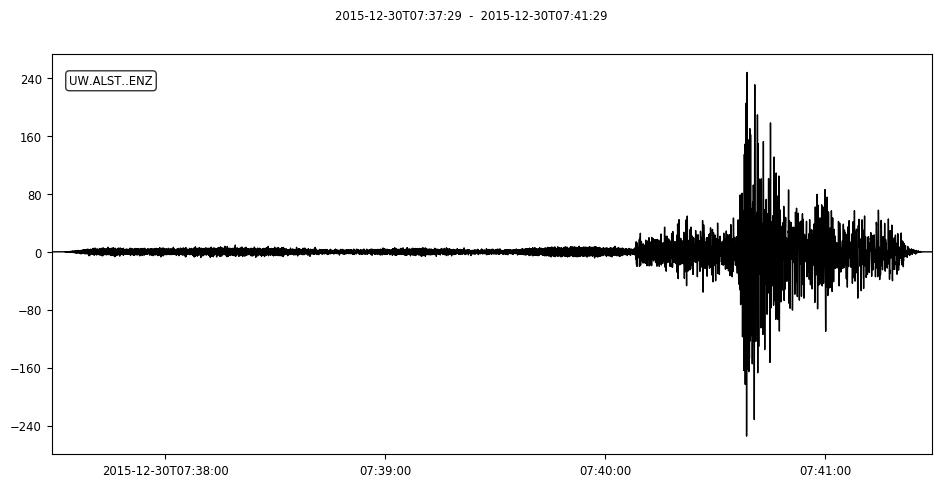

In [11]:
# Remove zero pad
ALST_tr_pad.trim(endtime=before_padding_endtime)
ALST_tr_pad.plot(size=size)

In [12]:
import numpy as np
from scipy.optimize import curve_fit

def poly_func(x, a, b, c, d, e):
        """
        Model polynomial function for polynomial baseline correction.
        """
        return a*x**6 + b*x**5 + c*x**4 + d*x**3 + e*x**2

def correct_baseline_and_plot(trace):
    """
    Performs a baseline correction following the method of Ancheta
    et al. (2013). This removes low-frequency, non-physical trends
    that remain in the time series following filtering.

    Args:
        trace (obspy.core.trace.Trace): Trace of strong motion data.

    Returns:
        trace (obspy.core.trace.Trace): Baseline-corrected trace.
    """

    # Make copies of the trace for our accleration data
    orig_trace = trace.copy()
    acc_trace = trace.copy()

    # Integrate twice to get the displacement time series
    disp_trace = (acc_trace.integrate()).integrate()

    # Fit a sixth order polynomial to displacement time series, requiring
    # that the 1st and 0th order coefficients are zero
    time_values = np.linspace(0, trace.stats.npts-1, trace.stats.npts)
    poly_cofs = list(curve_fit(poly_func, time_values, disp_trace.data)[0])
    poly_cofs += [0, 0]

    # Construct a polynomial from the coefficients and compute
    # the second derivative
    polynomial = np.poly1d(poly_cofs)
    print(polynomial)

    plt.figure(figsize=(20,6))
    plt.plot(disp_trace.data, label='Displacement time series')
    plt.plot(polynomial(time_values), label='6th order polynomial fit')
    plt.legend(fontsize=20)
    plt.plot()

    polynomial_second_derivative = np.polyder(polynomial, 2)

    # Subtract the second derivative of the polynomial from the
    # acceleration trace
    for i in range(orig_trace.stats.npts):
        orig_trace.data[i] -= polynomial_second_derivative(i)
    return orig_trace

          6             5             4            3             2
3.53e-32 x - 2.606e-27 x + 7.293e-23 x - 9.54e-19 x + 5.716e-15 x


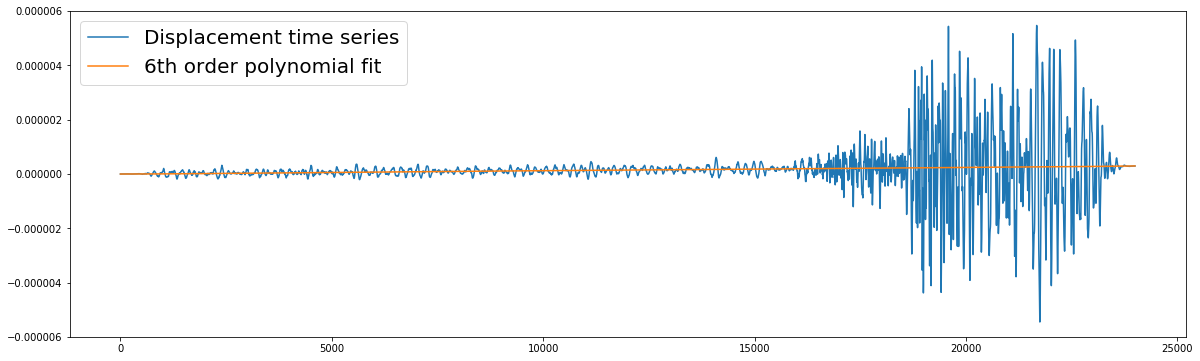

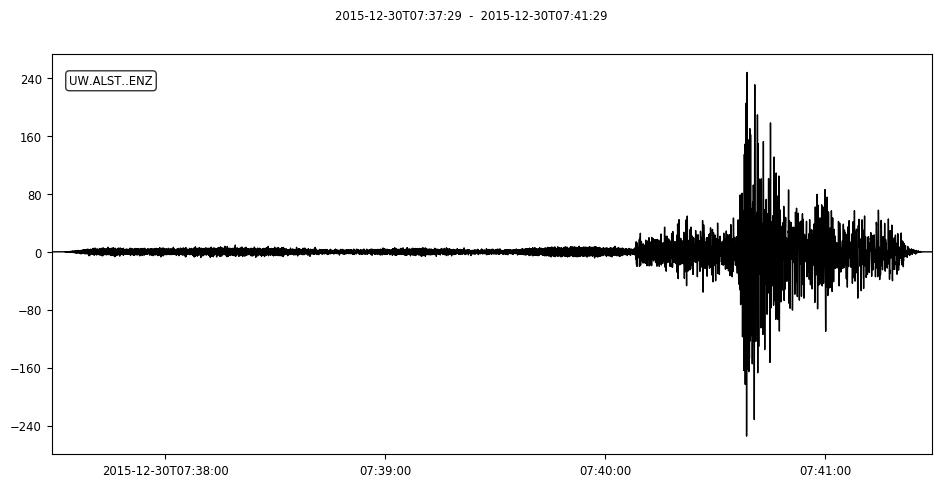

In [13]:
# Correct baseline
ALST_tr_cor = correct_baseline_and_plot(ALST_tr_pad)
ALST_tr_cor.plot(size=size)

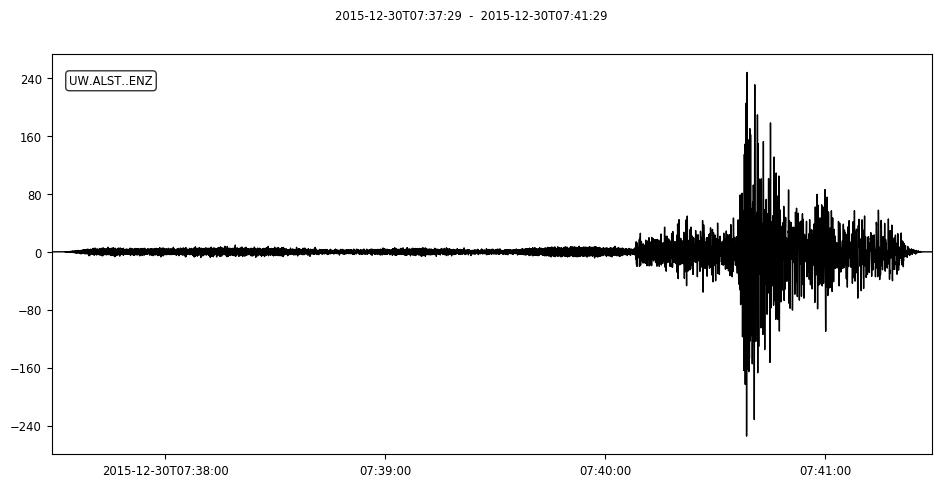

In [4]:
# Processing from a configuration
my_config = {
        'processing_parameters': {
                'amplitude': {
                        'min': 10e-9,
                        'max': 10.0
                },
                'window': {
                        'vmin': 1.0
                },
                'taper': {
                        'type': 'hann',
                        'max_percentage': 0.05,
                        'side': 'both'
                },
                'corners': {
                        'get_dynamically': True,
                        'sn_ratio': 3.0,
                        'max_low_freq': 0.5,
                        'min_high_freq': 5.0,
                        'default_low_frequency': 0.1,
                        'default_high_frequency': 20.0
                },
                'filters': [{
                        'type': 'highpass',
                        'corners': 5,
                        'zerophase': True
                },{
                        'type': 'lowpass',
                        'corners': 5,
                        'zerophase': True
                }],
                'baseline_correct': True,
        }
}

ALST_cor = process.process_config(ALST_st, my_config, org_time, ALST_tr.stats.sac.dist)
ALST_cor.plot(size=size)

In [5]:
print(ALST_cor[0].stats['processing_parameters'])

AttribDict({'filters': [[[{'corners': 5, 'zerophase': True, 'type': 'highpass'}], {'corners': 5, 'zerophase': True, 'type': 'lowpass'}]], 'amplitude': AttribDict({'min': 1e-08, 'max': 10.0}), 'baseline_correct': True, 'window': AttribDict({'vmin': 1.0}), 'taper': AttribDict({'max_percentage': 0.05, 'side': 'both', 'type': 'hann'}), 'corners': AttribDict({'default_high_frequency': 11.3067626953125, 'default_low_frequency': 0.439453125, 'get_dynamically': True, 'max_low_freq': 0.5, 'sn_ratio': 3.0, 'min_high_freq': 5.0})})


In [15]:
# Failing test example
ALST_tr_mul.data *= 10000000
ALST_st_mul = Stream(ALST_tr_mul)
ALST_mul_proc = process.process_config(ALST_st_mul, my_config, org_time, ALST_tr.stats.sac.dist)
print(ALST_mul_proc[0].stats['passed_tests'])
print(ALST_mul_proc[0].stats['standard']['comments'])


False
Processing: Trace maximum amplitude is not within the acceptable range: 1e-08 to 10.0. Skipping processing for trace: <obspy.core.trace.Trace object at 0x119f803c8>
